# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

## Notebook 06. Labelled Dataset - Off the shelf sentiment analysing models applied

The code is adapted from here: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

In [241]:
#from google.colab import drive
#drive.mount('/content/drive')

In [242]:
#!pip install transformers

In [243]:
# Import standard data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('ggplot')

# Import NLP libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download necessary datasets for nltk
nltk.download('punkt')          # Tokenizers
nltk.download('vader_lexicon')  # Lexicon for Sentiment Analysis

# Import progress bar utility
from tqdm.notebook import tqdm

# Initialize Sentiment Intensity Analyzer (VADER)
sia = SentimentIntensityAnalyzer()

# RoBERTa Sentiment Analyzer packages
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

[nltk_data] Downloading package punkt to /Users/lgfolder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lgfolder/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [244]:
from transformers import pipeline

# Define the model path
model_path = "cardiffnlp/twitter-roberta-base-sentiment"

# Load the sentiment analysis pipeline
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Perform sentiment analysis
result = sentiment_task("only loosers would buy gamestop")

print(result)

[{'label': 'LABEL_1', 'score': 0.542090654373169}]


In [245]:
# Read in data
df = pd.read_csv('../data/03_labelled_GPT_upsampled_.csv')
print(df.shape)
#df = df.head(1000)
#print(df.shape)

(5443, 4)


In [246]:
df.head()

,Unnamed: 0,id,Text,Intent
0,0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,1,t3_ki3745,"Oh GME, you tease!",u
2,2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,4,t3_l9xqem,Just got into $GME @ 220.,y


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443 entries, 0 to 5442
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5443 non-null   int64 
 1   id          5443 non-null   object
 2   Text        5443 non-null   object
 3   Intent      5443 non-null   object
dtypes: int64(1), object(3)
memory usage: 170.2+ KB


In [248]:
# Assuming df is your DataFrame
df = df.rename(columns={'Unnamed: 0': 'Idx'})

In [249]:
# Check if there are any missing values in the 'Text' column
print("Missing values in 'Text' column:", df['Text'].isnull().sum())

# Print the first few rows of the DataFrame to inspect the data
print("First few rows of the DataFrame:")
print(df.head())

Missing values in 'Text' column: 0
First few rows of the DataFrame:
   Idx         id                                               Text Intent
0    0  t3_l71j1l  GME &amp; BB are not on cashapp but AMC &amp; ...      i
1    1  t3_ki3745                                 Oh GME, you tease!      u
2    2  t3_la75n9  Dump gme, amc, nok, and bb so we can all buy s...      u
3    3  t3_lw6hoh  Not a single decent DD posted? 9 billion in re...      u
4    4  t3_l9xqem                          Just got into $GME @ 220.      y


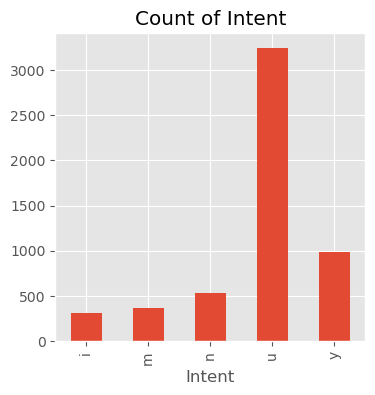

In [250]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(4, 4))
ax.set_xlabel('Intent')
plt.show()

In [251]:
example = df['Text'][2]
print(example)

Dump gme, amc, nok, and bb so we can all buy silver!


In [252]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Dump gme, amc, nok, and bb so we can all buy silver!


{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.4389}

# RoBERTa and VADER sentiment analyser

In [253]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [254]:
# Maximum token limit for the RoBERTa model
max_token_limit = tokenizer.model_max_length

# Iterate through the DataFrame rows to check whether text exceeds maximum number of tokens
for index, row in df.iterrows():
    text = row['Text']
    # Tokenize the text
    tokens = tokenizer(text, return_tensors="pt")
    # Get the number of tokens in the text
    num_tokens = len(tokens['input_ids'][0])
    
    # Check if the number of tokens exceeds the maximum limit
    if num_tokens > max_token_limit:
        print(f"Row {index} has too many tokens ({num_tokens} tokens):")
        print(text)

In [255]:
# Sample text for tokenization
sample_text = "only losers would buy gamestop"

# Tokenize the sample text
tokens = tokenizer(sample_text, return_tensors="pt")
print(tokens)

{'input_ids': tensor([[    0,  8338, 19113,    74,   907, 20577,   990,  1517,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Code to check the model input:

In [256]:
# Example input tensor (replace with your tokenized input)
input_ids = tokens["input_ids"][0]  # Input_ids is a tensor that contains the token IDs of the tokenized input text
attention_mask = tokens["attention_mask"] # tells the model which tokens are "real" words and which ones are padding tokens

# Ensure the input tensor shape matches the model's input requirements
print("Input IDs shape:", input_ids.shape)
print("Attention mask shape:", attention_mask.shape)

# Forward pass through the model to get predictions (for debugging)
output = model(input_ids.unsqueeze(0), attention_mask=attention_mask) # applies the model to the input, adding an extra dimension to the tensor to make it compatible with batch processing, where the batch size is 1
print("Model output:", output)


Input IDs shape: torch.Size([9])
Attention mask shape: torch.Size([1, 9])
Model output: SequenceClassifierOutput(loss=None, logits=tensor([[ 1.9040,  0.2803, -2.1438]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [257]:
# Run for Roberta Model for one example to test it
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.18812548, 'roberta_neu': 0.6091106, 'roberta_pos': 0.20276392}


In [258]:
# Define RoBERTa function to iterate through df rows

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [259]:
# VADER and RoBERTa sentiment - to label the recordswith sentiment ratings (takes a long time!)
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Idx']  # Use the 'Idx' column as the identifier
        vader_result = sia.polarity_scores(text)  # SIA polarity scores
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)  # RoBERTa results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for index {i}')

  0%|          | 0/5443 [00:00<?, ?it/s]

Broke for index 39
Broke for index 182
Broke for index 366
Broke for index 767
Broke for index 975
Broke for index 1059
Broke for index 1095
Broke for index 1104
Broke for index 1117
Broke for index 1132
Broke for index 1155
Broke for index 1172
Broke for index 1417
Broke for index 2024
Broke for index 2229
Broke for index 2650
Broke for index 2657
Broke for index 2984
Broke for index 3061
Broke for index 3103
Broke for index 3117
Broke for index 3254
Broke for index 3263
Broke for index 3595
Broke for index 3851
Broke for index 4074
Broke for index 4154
Broke for index 4250
Broke for index 4260
Broke for index 4731
Broke for index 4913
Broke for index 5214
Broke for index 5241
Broke for index 5292
Broke for index 5300


In [260]:
# Recording the results in new columns in results_df
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Idx'})  
results_df = results_df.merge(df, how='left')

In [261]:
# Check for missing values in the merged DataFrame (results_df)
missing_values = results_df.isnull().sum()
print("Missing values in the merged DataFrame:")
print(missing_values)

Missing values in the merged DataFrame:
Idx               0
vader_neg         0
vader_neu         0
vader_pos         0
vader_compound    0
roberta_neg       0
roberta_neu       0
roberta_pos       0
id                0
Text              0
Intent            0
dtype: int64


In [262]:
results_df.head(10)

,Idx,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,id,Text,Intent
0,0,0.000,1.000,0.000,0.0000,0.077612,0.861043,0.061345,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,1,0.464,0.536,0.000,-0.3802,0.757429,0.207618,0.034953,t3_ki3745,"Oh GME, you tease!",u
2,2,0.208,0.792,0.000,-0.4389,0.188125,0.609111,0.202764,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,3,0.000,0.839,0.161,0.8555,0.397933,0.467978,0.134089,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,4,0.000,1.000,0.000,0.0000,0.016767,0.866622,0.116611,t3_l9xqem,Just got into $GME @ 220.,y
5,5,0.000,1.000,0.000,0.0000,0.007889,0.250370,0.741741,t3_lx47v2,GME went up to 131$ in AH and is now breaking ...,u
6,6,0.000,1.000,0.000,0.0000,0.003273,0.125159,0.871568,t3_l2lfqs,Just doubled my position on GMELet’s HOLDDDDDD...,y
7,7,0.143,0.857,0.000,-0.5411,0.596437,0.365049,0.038515,t3_l68y04,"Do not sell GME, BUY THE DIP! Big Money will ...",u
8,8,0.000,1.000,0.000,0.0000,0.085476,0.868586,0.045938,t3_kjyzh7,Do you currently still plan on getting back in...,u
9,9,0.082,0.723,0.195,0.7548,0.316744,0.516255,0.167002,t3_l7wprt,I am not giving into the hype yet. I want to ...,m


In [263]:
# Checking the value counts again
value_counts = results_df['Intent'].value_counts()
print(value_counts)

Intent
u    3224
y     982
n     529
m     368
i     305
Name: count, dtype: int64


/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


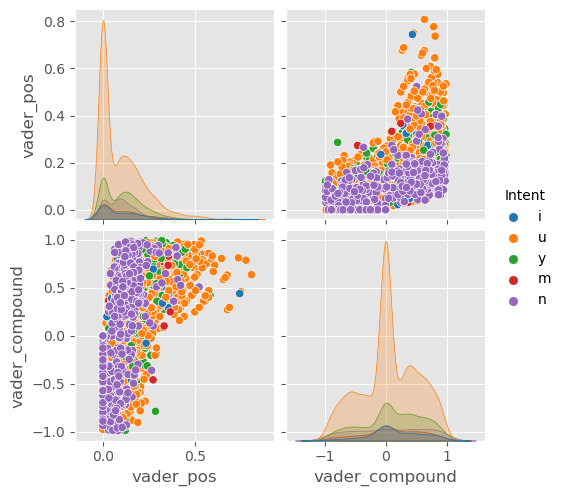

In [264]:
sns.pairplot(data=results_df,
             vars=['vader_pos',
                   'vader_compound'],
            hue='Intent',
            palette='tab10')
plt.show()

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


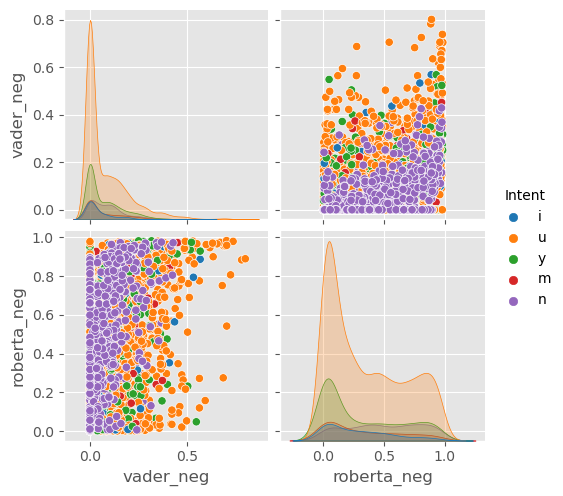

In [265]:
sns.pairplot(data=results_df,
             vars=['vader_neg',
                  'roberta_neg'],
            hue='Intent',
            palette='tab10')
plt.show()

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


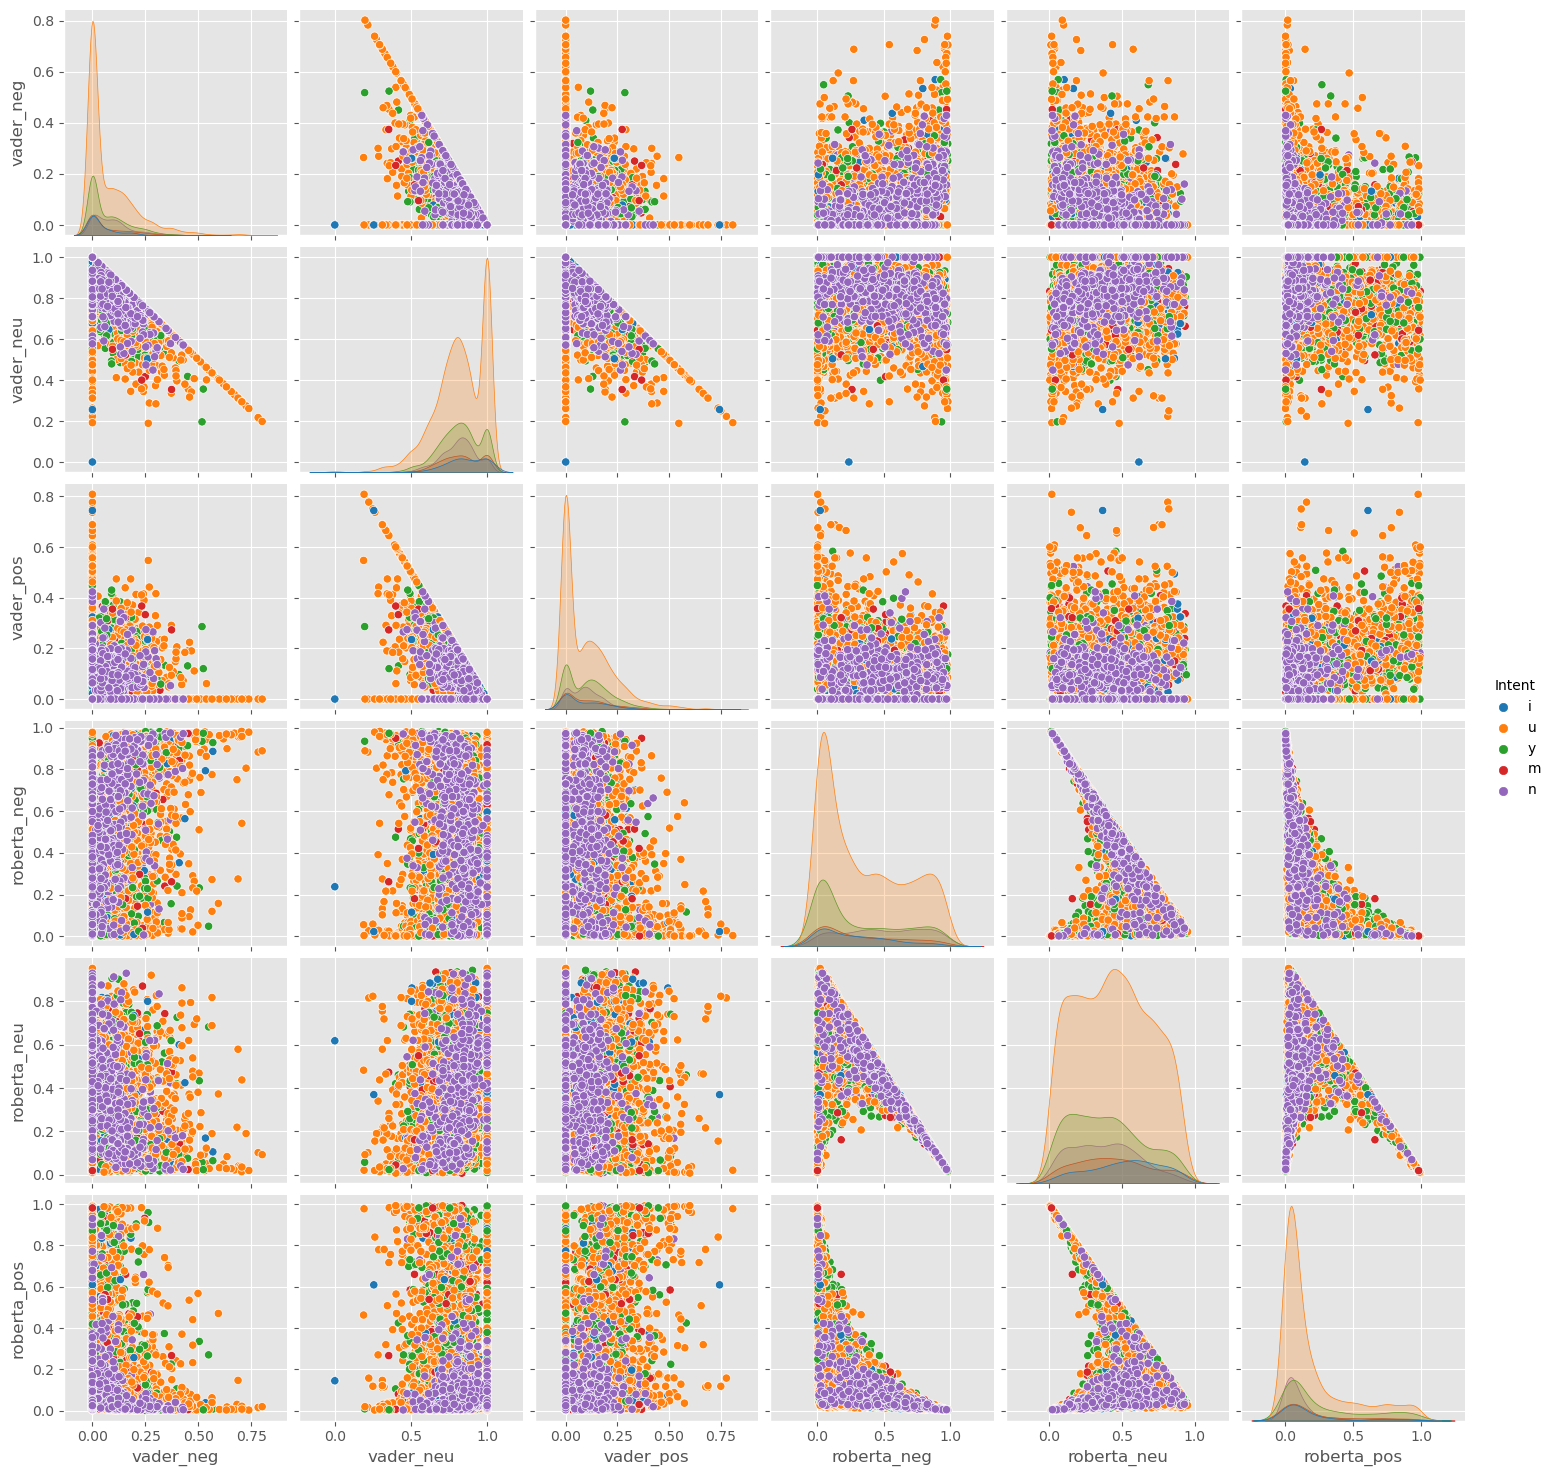

In [266]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Intent',
            palette='tab10')
plt.show()

Examples of positive sentiment identified correctly:

In [267]:
results_df.query('Intent == "y"') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"Just bought 1 share on Fidelity. I'm proud to be part of this with you all. Gamestop has a bright future and I REALLY LIKE THE STOCK!!!"

In [268]:
results_df.query('Intent == "y"') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'lucky I have gme'

Examples of negative sentiment identified correctly:

In [269]:
results_df.query('Intent == "n"') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[1]

"It absolutely blows my mind that so many people and especially people on this sub are STILL using Robinhood despite what happened with the whole gamestop fiasco., There's still so many people using Robinhood after all the GME crap. And what really blows my mind is that I see people here on this very sub using Robinhood everyday? It absolutely baffles the living shit out of me as to why you are still using something that screwed you over, especially knowing very well that it could happen again and screw you over AGAIN. I don't want to see anyone who gets screwed over by Robinhood yet again complaining about it. You asked for it buddy.I know you stock market types only care about profit but godamn what kind of abusive relationship is this. This is mainly why I switched to the other market and projects like Merrymen who aim to undo this shit. What kind of abusive relationship do you people have with Robinhood. They give you a slick UI and you forget about all the wrongs they did to you? 

In [270]:
results_df.query('Intent == "n"') \
    .sort_values('vader_neg', ascending=False)['Text'].values[1]

'Inflow>outflow but gme prices still go down. Wtf, '

Below are examples of misclassifications:

In [271]:
results_df.query('Intent == "y"') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"Why does citron fuck with every ticker I'm in. Nio, then pltr, now gme. Fuck those guys."

In [272]:
results_df.query('Intent == "n"') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'This is the best day of my life. Never bought any options before but with GME pumped up so high bought puts on Friday. Cashed those babies in today for a 30k profit!'

In [273]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [274]:
sent_pipeline('Exactly, oh well people thumbing this shit down just want to pump their bags and cash out on call premiums convincing people to buy them because”SQUEEZE WILL HAPPEN ANY DAY NOW GME $1000”. I feel bad, but mehhhhh, as more people blow up their accounts I hope a large chunk of them think twice about buying into a dead play. Oh well')

[{'label': 'NEGATIVE', 'score': 0.9977630376815796}]

In [275]:
sent_pipeline("PLEASE DON'T BE SMART AND SELL GME")

[{'label': 'NEGATIVE', 'score': 0.9995328187942505}]

In [276]:
sent_pipeline("PLEASE DON'T BE SMART AND BUY GME")

[{'label': 'NEGATIVE', 'score': 0.9993476271629333}]

In [277]:
sent_pipeline("only loosers would sell gamestop")

[{'label': 'NEGATIVE', 'score': 0.9728075265884399}]

In [278]:
sent_pipeline("only loosers would buy gamestop")

[{'label': 'NEGATIVE', 'score': 0.9890828132629395}]

In [279]:
sent_pipeline("🚀🚀🚀🚀🚀🚀🚀")

[{'label': 'NEGATIVE', 'score': 0.6970564126968384}]

In [280]:
sent_pipeline("🌙")

[{'label': 'NEGATIVE', 'score': 0.6970564126968384}]

In [281]:
sent_pipeline("💎🙌")

[{'label': 'NEGATIVE', 'score': 0.6970564126968384}]

In [282]:
sent_pipeline("apes 🦍")

[{'label': 'NEGATIVE', 'score': 0.7105820775032043}]

In [283]:
sent_pipeline("WE ARE PLUS 430!!! 🌙  🦍 WE ARE DOING IT. NOW KEEP HOLDING AND DONT GIVE INTO WHAT THEY WANT. IT WILL BE 600 BEFORE THE DAYS OUT AND THEN MONDAY IT WILL OPEN AT $1000 🤞 IF NOT THEN JUST A LITTLE LESS. BUY BUY BUY PEOPLE THIS IS STILL ONLY THE BEGINNING!!! AND DONT SELL WHEN YOU SEE THE DROP THIS MORNING THIS IS WHAT THEY WANT YOU TO DO AND THEN THEY WILL MAKE IT SO YOU CAN BUY ANYMORE STOCKS OR GAME STOP LIKE THEY DONE YESTERDAY BUT WE ARE NOT STUPID!! HOLDING AND NOT SELLING AND BUYING MORE HERE WHEN LAME ASS ROBINHOOD OPENS. HOLD HOLD HOLD. TO THE MOON🚀🚀🚀🚀🚀🚀🚀")

[{'label': 'NEGATIVE', 'score': 0.7619146108627319}]

In [284]:
# Recording the processed dataset as a new csv file to be used in future:
results_df.to_csv('../data/06_labelled_dataset_VADER.csv', index=False)

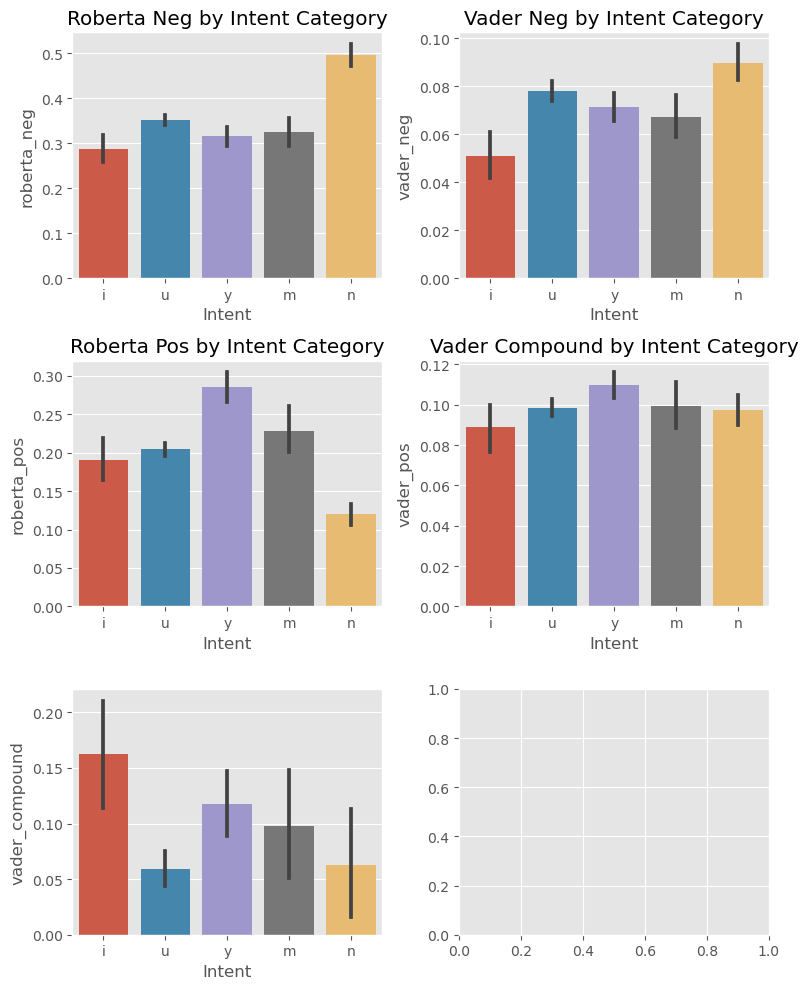

In [285]:
# Plotting graphs to show the distribution of Vader ratings
fig, axes = plt.subplots(3, 2, figsize=(8, 10))


sns.barplot(ax=axes[0, 0], data=results_df, x='Intent', y='roberta_neg')
axes[0, 0].set_title('Roberta Neg by Intent Category')

sns.barplot(ax=axes[0, 1], data=results_df, x='Intent', y='vader_neg')
axes[0, 1].set_title('Vader Neg by Intent Category')

sns.barplot(ax=axes[1, 0], data=results_df, x='Intent', y='roberta_pos')
axes[1, 0].set_title('Roberta Pos by Intent Category')

sns.barplot(ax=axes[1, 1], data=results_df, x='Intent', y='vader_pos')
axes[1, 1].set_title('Vader Pos by Intent Category')

sns.barplot(ax=axes[2, 0], data=results_df, x='Intent', y='vader_compound')
axes[1, 1].set_title('Vader Compound by Intent Category')


plt.tight_layout()
plt.show()

In [286]:
fig.savefig('../data/labelled_RoBERTa_sentiment.png', dpi=120)